In [161]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt             
import matplotlib as mpl                    
mpl.rc('font', family='Malgun Gothic')      
plt.rcParams['axes.unicode_minus']=False  

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_validate
from sklearn.metrics import r2_score
import random

import tensorflow as tf
from tensorflow import keras     
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics

from tensorflow.keras.layers import LSTM

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# 전력 예측
- 데이터: https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014
- 날짜와 특정지역코드(MT_001~ MT_370)로 구성
    - 행(Row): 140,256개의 타임스탬프(매 15분 단위)
    - 열(Column): 370개의 소비 지역(전력 미터 ID)
    - 형식: timestamp (DatetimeIndex) + 370개의 소비량 열

## 데이터 전처리

In [4]:
np.random.seed(42)       
tf.random.set_seed(42)   
random.seed(42)

In [5]:
data=pd.read_csv("./Data/LD2011_2014.txt", 
                 sep=";", 
                 index_col=0, 
                 parse_dates=True,  # 날짜처럼 보이는 문자열을 자동으로 datetime
                 decimal=",")
data.shape

(140256, 370)

In [11]:
elec=data.copy()

- 데이터 로드
- 일변 소비량 합산 (평균)
- 평균을 기준으로 High(1)/Low(0) 라벨 생성
- 스케일 조절

In [14]:
# elec.shape
# elec.head(2)
elec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0 MB


In [16]:
# 데이터 리샘플링 (일별 소비량 합산)
daily_elec=elec.resample("D").sum()   # S, T, M, D, W, M, Q, Y
daily_elec.shape

(1462, 370)

In [18]:
# daily_elec.describe()

# 결측치
# daily_data.fillna(method="ffill", inplace=True)

In [20]:
# 임계값 계산 (전체 평균)
threshold=daily_elec.mean(axis=1).mean()
threshold

50704.3933356309

In [22]:
# 새로운 분류 라벨 추가  : 1, 0
daily_elec['label']=np.where(daily_elec.mean(axis=1) > threshold, 1, 0)

In [24]:
daily_elec["label"].value_counts()

label
0    742
1    720
Name: count, dtype: int64

In [26]:
daily_elec.tail()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,label
2014-12-28,227.157360,2131.578947,151.172893,14327.235772,6776.829268,20122.023810,429.621255,25255.892256,5118.881119,4794.623656,...,3272100.0,220721.518987,257477.272727,8169.491525,552.369807,45914.837577,4405.676127,66135.630499,1.553189e+06,1
2014-12-29,248.730964,2212.660028,160.729800,14067.073171,7198.780488,22824.404762,550.593556,30286.195286,6697.552448,6337.634409,...,3109100.0,206852.320675,269090.909091,8438.070404,1153.891164,53928.884987,12914.858097,73882.697947,1.806486e+06,1
2014-12-30,232.233503,2205.547653,165.073849,14290.650407,7189.024390,23880.952381,586.772188,30909.090909,6487.762238,6489.247312,...,2904300.0,204126.582278,263613.636364,10615.384615,892.334699,56334.503951,15996.661102,73950.146628,1.867568e+06,1
2014-12-31,229.695431,2273.115220,166.811468,14006.097561,7023.170732,23511.904762,690.785755,28700.336700,6211.538462,5034.408602,...,2748800.0,162556.962025,215886.363636,7415.906128,530.134582,50259.877085,13245.409015,70416.422287,1.365892e+06,0
2015-01-01,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.175240,249.158249,62.937063,69.892473,...,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7.135135e+03,0


In [28]:
daily_X=daily_elec.drop(['label'], axis=1)
daily_Y=daily_elec['label']
daily_X.shape, daily_Y.shape

((1462, 370), (1462,))

In [30]:
min_max_scaler=MinMaxScaler()
min_max_scaled=min_max_scaler.fit_transform(daily_X)

In [32]:
def make_sample(data, labels, seq_length):
    train, target=[], []
    for i in range(len(data) - seq_length):
        train.append(data[i: i+seq_length])        
        target.append(labels[i + seq_length])       
    return np.array(train), np.array(target)

In [34]:
seq_length=30

# 데이터 셋
X, Y=make_sample(min_max_scaled, daily_Y.values, seq_length)
X.shape, Y.shape

((1432, 30, 370), (1432,))

In [36]:
X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.3, shuffle=False)
X_train.shape, X_test.shape

((1002, 30, 370), (430, 30, 370))

## LSTM

In [47]:
model=keras.Sequential()
model.add(keras.layers.Input(shape=(seq_length, 370)))                         # LSTM 입력 크기
model.add(keras.layers.LSTM(64, activation='tanh', return_sequences=False))    # 시퀀스 중 마지막 상태만 출력 
model.add(keras.layers.Dense(1, activation='sigmoid'))                         # 출력층
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │         111,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,425 (435.25 KB)

 Trainable params: 111,425 (435.25 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
def on_epoch_end_fun(epoch, logs):  
    if(epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: loss={logs['loss']:.4f}, accuracy={logs['accuracy']:.4f}", 
              f"val_loss={logs['val_loss']:.4f}, val_accuracy={logs['val_accuracy']:.4f}")

        
# 각 에포크가 끝날 때 on_epoch_end 함수
print_callback=LambdaCallback(on_epoch_end=on_epoch_end_fun)

# 학습 중단
early_stopping_callback=EarlyStopping(monitor='val_loss',       
                                      patience=10,                  # epoch 동안 개선이 없으면 학습 중단
                                      verbose=1,                    # early stopping 메시지 출력
                                      restore_best_weights=True)    # 가장 좋은 가중치 복원    

In [51]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
history=model.fit(X_train, Y_train,
                  epochs=100, batch_size=16, verbose=0, 
                  validation_data=(X_test, Y_test), shuffle=False, 
                  callbacks=[print_callback, early_stopping_callback])  

Epoch 10: loss=0.4840, accuracy=0.6607 val_loss=0.6081, val_accuracy=0.8070
Epoch 20: loss=0.2123, accuracy=0.9411 val_loss=0.4735, val_accuracy=0.8070
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 19.


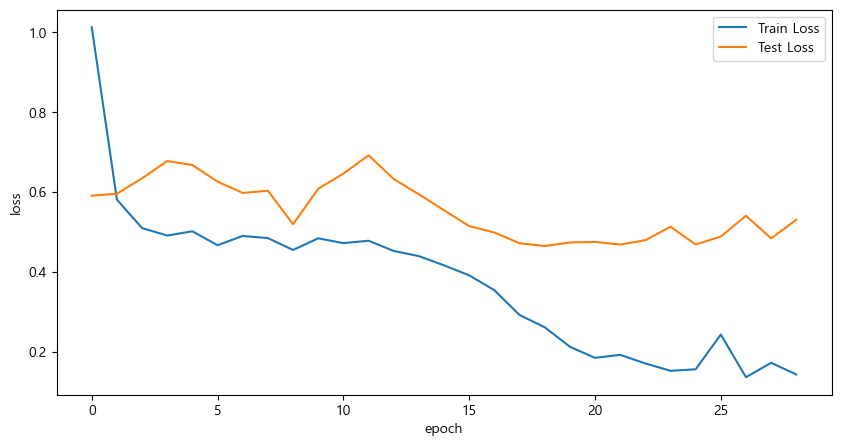

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [57]:
test_loss, test_mse=model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}")    # 위 loss 평균, 실제값

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7613 - loss: 0.5422
Test Loss: 0.4647, Test MSE: 0.8070


In [59]:
pred_prob=model.predict(X_test)
pred_prob[0]

pred_class=(pred_prob > 0.5).astype(int)
pred_class[0], Y_test[0]

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


(array([1]), 1)

In [61]:
metrics.accuracy_score(Y_test, pred_class)

0.8069767441860465

In [63]:
# print(metrics.classification_report(Y_test, pred_class))

## RandomForestClassifier

In [170]:
X.shape

(1432, 30, 370)

In [172]:
X_falt=X.reshape(X.shape[0], -1) 
X_falt.shape

(1432, 11100)

In [174]:
# 타입 스텝 가능함
pca=PCA(n_components=0.95)               # 분산의 95%를 유지하는 차원 선택
X_pca=pca.fit_transform(X_falt)
X_pca.shape

(1432, 34)

In [175]:
X_train, X_test, Y_train, Y_test=train_test_split(X_pca, Y, test_size=0.3, shuffle=False)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1002, 34), (1002,), (430, 34), (430,))

In [176]:
forest=RandomForestClassifier(max_depth=5, random_state=42)
forest.fit(X_train, Y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [76]:
forest.score(X_train, Y_train), forest.score(X_test, Y_test)

(0.9820359281437125, 0.586046511627907)

In [78]:
# 검증
tscv=TimeSeriesSplit(n_splits=5)   # 시계열 데이터를 시간 순서를 유지하면서 훈련/검증 세트
scores=cross_validate(forest, X_train, Y_train, return_train_score=True, cv=tscv)

In [177]:
 np.mean(scores['train_score']), np.mean(scores['test_score'])

(0.9961077844311378, 0.8071856287425151)

### 최적화

In [203]:
from scipy.stats import randint, uniform

params={
    'n_estimators': randint(50, 500),                 
    'max_depth': randint(3, 10),                        # 트리 갯수                       
    'min_samples_split': randint(5, 20),                # 노드 분할에 필요한 최소 샘플수 
    'min_samples_leaf': randint(5, 20),                 # 끝에 있는 노드에 적어도 몇 개의 샘플수    
}

In [205]:
rs=RandomizedSearchCV(RandomForestClassifier(), 
                      params,  
                      n_jobs=-1, 
                      # cv=tscv, 
                      random_state=42)
rs.fit(X_train, Y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AC4E6B6DB0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AC4E6B65A0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AC4E6B51F0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AC4E6B4680>},
                   random_state=42)

In [207]:
print(rs.best_params_)        # 최적의 하이퍼파라미터 조합을 출력
print(rs.best_score_)         # 그 최적의 조합에서 교차 검증으로 얻어진 평균 점수  

{'max_depth': 6, 'min_samples_leaf': 12, 'min_samples_split': 12, 'n_estimators': 180}
0.731139303482587


In [209]:
rs_best=rs.best_estimator_
rs_best.score(X_train, Y_train), rs_best.score(X_test, Y_test)

(0.9700598802395209, 0.7209302325581395)

## SARIMAX

In [212]:
daily_X.shape, daily_Y.shape

((1462, 370), (1462,))

In [214]:
scaler=StandardScaler()
scaled=min_max_scaler.fit_transform(daily_X)

In [216]:
X_train, X_test, Y_train, Y_test=train_test_split(scaled, daily_Y, test_size=0.3, shuffle=False)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1023, 370), (439, 370), (1023,), (439,))

In [229]:
model=SARIMAX(Y_train, exog=X_train, order=(0, 1, 0))  
model_fit=model.fit(maxiter=1000)

In [231]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  label   No. Observations:                 1023
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 741.133
Date:                Tue, 15 Apr 2025   AIC                           -740.265
Time:                        20:41:24   BIC                           1088.586
Sample:                    01-01-2011   HQIC                           -45.909
                         - 10-19-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1203      0.113     -1.066      0.287      -0.341       0.101
x2             0.1842      0.180      1.023      0.307      -0.169       0.537
x3            -0.0768      0.174     -0.441      0.660      -0.418       0.265
x4            -0.0436      0.568     -0.077      0.939      -1.157       1.070
x5            -0.4009      0.303     -1.325      0.185      -0.994       0.192
x6             0.6299      0.493      1.277      0.202      -0.337       1.597
x7             0.3202      0.275      1.164      0.244      -0.219       0.859
x8             0.6475      0.521      1.242      0.214      -0.375       1.669
x9            -0.1628      0.171     -0.953      0.341      -0.497       0.172
x10            0.0820      0.127      0.645      0.519      -0.167       0.332
x11            0.3011      0.389      0.773      0.439      -0.462       1.064
x12            0.2580      0.775      0.333      0.739      -1.260       1.776
x13            0.2843      0.328      0.866      0.387      -0.359       0.928
x14            0.0929      0.328      0.283      0.777      -0.551       0.737
x15            0.0341      0.292      0.117      0.907      -0.538       0.606
x16           -0.8998      0.406     -2.214      0.027      -1.696      -0.103
x17            0.7387      0.532      1.389      0.165      -0.303       1.781
x18            0.0588      0.299      0.197      0.844      -0.526       0.644
x19            0.3830      0.340      1.126      0.260      -0.283       1.050
x20            0.2315      0.282      0.820      0.412      -0.322       0.785
x21            0.4793      0.539      0.890      0.373      -0.576       1.535
x22           -0.2310      0.198     -1.165      0.244      -0.620       0.158
x23            0.4975      0.234      2.128      0.033       0.039       0.956
x24            0.1778      0.337      0.527      0.598      -0.484       0.839
x25           -0.2729      0.193     -1.413      0.158      -0.652       0.106
x26           -0.0198      0.384     -0.052      0.959      -0.772       0.732
x27           -0.9361      0.401     -2.334      0.020      -1.722      -0.150
x28            0.0256      0.343      0.075      0.941      -0.646       0.697
x29            0.0241      0.206      0.117      0.907      -0.380       0.428
x30           -0.1313      0.465     -0.282      0.778      -1.043       0.780
x31           -0.5235      0.552     -0.948      0.343      -1.606       0.559
x32           -0.3584      0.301     -1.190      0.234      -0.949       0.232
x33            0.7714      0.352      2.194      0.028       0.082       1.461
x34           -0.0428      0.369     -0.116      0.908      -0.767       0.681
x35            0.3197      0.339      0.944      0.345      -0.344       0.983
x36           -0.1130      0.214     -0.527      0.598      -0.533       0.307
x37            0.1019      0.285      0.358      0.721      -0.456       0.660
x38            0.3601      0.570      0.632      0.528      -0.757       1.478
x3

In [233]:
pred=model_fit.predict(start=Y_test.index[0], end=Y_test.index[-1], exog=X_test)

In [235]:
r2_score(Y_test, pred)  

-2.6005043923152527